In [19]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#load data
data = pd.read_csv('../../data/netflix_titles.csv')

In [20]:
#data cleaning
nulls = data.isnull().sum()
nulls

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [21]:
#delete all row with nans in date_added and rating and duration
data = data.dropna(subset=['date_added', 'rating', 'duration'])

In [22]:
#check incorrect values or formats in every columns, for exmample spaces in the beginning or end of the string
data['title'] = data['title'].str.strip()
data['director'] = data['director'].str.strip()
data['cast'] = data['cast'].str.strip()
data['country'] = data['country'].str.strip()
data['date_added'] = data['date_added'].str.strip()
data['rating'] = data['rating'].str.strip()

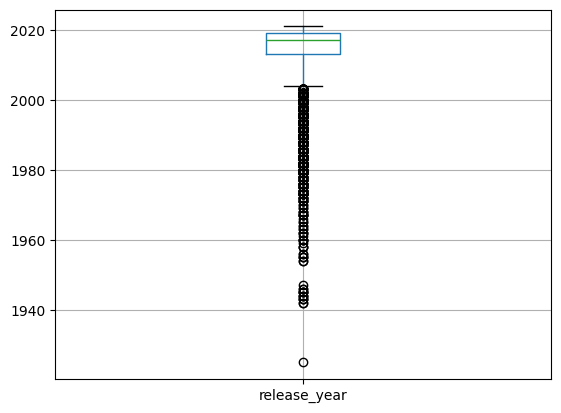

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
4250,s4251,TV Show,Pioneers: First Women Filmmakers*,NaN,NaN,NaN,"December 30, 2018",1925,TV-14,1 Season,TV Shows,This collection restores films from women who ...


In [23]:
#plot some boxplots to see the data distribution and to see if there are any outliers
data.boxplot(column='release_year')
plt.show()

#show release year lower than 1940
data[data['release_year'] < 1940]



In [24]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import pandas as pd

load_dotenv()

# Inicializa el cliente de OpenAI
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Carga tu dataset
df = data

# Define la función para obtener la completación
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
        max_tokens=3  # Limita la respuesta a 3 tokens
    )
    return response.choices[0].message.content

# Itera sobre tu dataset
for index, row in df.iterrows():
    # Si el director es un valor faltante
    if pd.isnull(row['director']):
        # Usa la descripción como prompt
        prompt = f"¿Quién es el director de esta película? {row['description']}, escribe solo el nombre nada más"
        # Obtiene la completación de la API de OpenAI
        completion = get_completion(prompt)
        # Asigna el valor generado al director
        print(f"Director de la película {row['title']}: {completion}")
        df.at[index, 'director'] = completion

Director de la película Blood & Water: Brent Daw
Director de la película Jailbirds New Orleans: Jonathan Stack
Director de la película Kota Factory: Nitesh
Director de la película Vendetta: Truth, Lies and The Mafia: Jed Roth
Director de la película Crime Stories: India Detectives: Ram Gopal
Director de la película Dear White People: Justin Simien
Director de la película Falsa identidad: Diego
Director de la película Jaguar: Chris Weitz
Director de la película Resurrection: Ertugrul: Osman K
Director de la película Love on the Spectrum: Brent K
Director de la película Chicago Party Aunt: Chris Witas
Director de la película Sex Education: Laurie
Director de la película Squid Game: Hwang Dong
Director de la película Tayo and Little Wizards: Tayo
Director de la película Angry Birds: Clay Kay
Director de la película Chhota Bheem: Rajiv
Director de la película He-Man and the Masters of the Universe: Aaron Nee
Director de la película Castle and Castle: Joel Sch
Director de la película Dharma

In [25]:
df.to_csv('Netflix_dataset_completado.csv', index=False)

In [1]:
from gensim.models import FastText
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

df = pd.read_csv('Netflix_dataset_completado.csv')
# Uso solo las primeras 500 entradas
df = df.head(500)

# Preprocesa las descripciones para FastText
descriptions = df['description'].apply(lambda x: x.split())

# Entrena el modelo FastText
model = FastText(descriptions, vector_size=100, window=5, min_count=1, workers=4)

# Calcula el embedding de cada descripción
df['embedding'] = descriptions.apply(lambda x: model.wv.get_vector(' '.join(x)))

# Encuentra las películas más similares a la primera
similarity_matrix = cosine_similarity(np.stack(df['embedding'].values))
most_similar = np.argsort(similarity_matrix[0])[-5:][::-1]

print("Películas más similares a:", df.iloc[0]['title'])
for i in most_similar:
    print(df.iloc[i+1]['title'])

Películas más similares a: Dick Johnson Is Dead
Blood & Water
Oggy Oggy
The Last Boy Scout
Gurgaon
If I Leave Here Tomorrow: A Film About Lynyrd Skynyrd


In [2]:
def search_by_name(name):
    return df[df['title'].str.contains(name, case=False, na=False)].to_dict('records')

def search_by_director(director):
    return df[df['director'].str.contains(director, case=False, na=False)].to_dict('records')

def recommend_movies(title):
    if title in df['title'].values:
        idx = df[df['title'] == title].index[0]
        most_similar = np.argsort(similarity_matrix[idx])[-5:][::-1]
        return df.iloc[most_similar].to_dict('records')
    else:
        return "Movie not found."


In [3]:
import gradio as gr

def handle_request(request_type, query):
    if request_type == 'Search by name':
        return search_by_name(query)
    elif request_type == 'Search by director':
        return search_by_director(query)
    elif request_type == 'Recommend movies':
        return recommend_movies(query)
    else:
        return "Invalid request type."

iface = gr.Interface(fn=handle_request, 
                     inputs=[gr.Dropdown(["Search by name", "Search by director", "Recommend movies"]), gr.Textbox()], 
                     outputs="dataframe")

iface.launch()

/opt/anaconda3/envs/devenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/opt/anaconda3/envs/devenv/lib/python3.10/site-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/opt/anaconda3/envs/devenv/lib/python3.10/site-packages/gradio/route_utils.py", line 270, in call_process_api
    output = await app.get_blocks().process_api(
  File "/opt/anaconda3/envs/devenv/lib/python3.10/site-packages/gradio/blocks.py", line 1856, in process_api
    data = await self.postprocess_data(fn_index, result["prediction"], state)
  File "/opt/anaconda3/envs/devenv/lib/python3.10/site-packages/gradio/blocks.py", line 1684, in postprocess_data
    prediction_value = block.postprocess(prediction_value)
  File "/opt/anaconda3/envs/devenv/lib/python3.10/site-packages/gradio/components/dataframe.py", line 311, in postprocess
    return DataframeData(headers=_headers, data=value)
  File "/opt/anaconda3/envs/devenv/lib/python3.10/site-packages/pydantic/main.py", line 176, in _

In [ ]:
def recommendation(reference_movie_index):
# Si existe el fichero con la matriz lo cargamos, si no llamamos a train_recommendation
try:
tfidf_matrix = load_tfidf_matrix()
except:
tfidf_matrix = train_recommendation()

cosine_sim_scores = cosine_similarity(
tfidf_matrix[reference_movie_index], tfidf_matrix)

# Obtener inidices de máximo indice de similaridad (excluyendo la película seleccionada)
similar_movie_indices = cosine_sim_scores.argsort()[0][::-1][1:]

# Obtener top N similar movies
top_N = 10 # Numero desdea de recomendaciones
recommended_movies = movies.iloc[similar_movie_indices[:top_N]]
print(type(recommended_movies['title']))
return 